In [10]:
library(tidyverse)
install.packages("janitor")
library(janitor)

also installing the dependency ‘snakecase’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done


Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test




Hello

New names:
• `` -> `...1`
Rows: 500 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (25): Age, Country, Plays, Wikipedia, Current Rank, Best Rank, Name, Bac...
dbl (13): ...1, Turned Pro, Seasons, Titles, Best Season, Retired, Masters, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“Expected 2 pieces. Additional pieces discarded in 2 rows [146, 441].”
Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 412 rows [2, 3, 4, 5, 6,
7, 8, 9, 10, 11, 12, 13, 14, 15, 18, 19, 20, 21, 22, 23, ...].”


current_rank,points,current_elo_rank,current_elo,dollar,prize_money,temp,age,dob
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
378,(97),NA,NA,NA,NA,NA,26,(25-04-1993)
326,(119),NA,NA,,"59,040",NA,18,(22-12-2001)
178,(280),144,(1764),US,"3,261,567",NA,32,(03-11-1987)
236,(199),NA,NA,,"374,093",NA,21,(29-05-1998)
183,(273),100,(1826),US,"6,091,971",NA,27,(21-10-1992)
31,(1398),33,(1983),,"1,517,157",NA,22,(11-02-1997)
307,(131),NA,NA,,"278,709",NA,28,(18-11-1991)
232,(205),NA,NA,,"59,123",NA,21,(12-05-1998)
417,(81),189,(1602),,"122,734",NA,25,(29-07-1994)


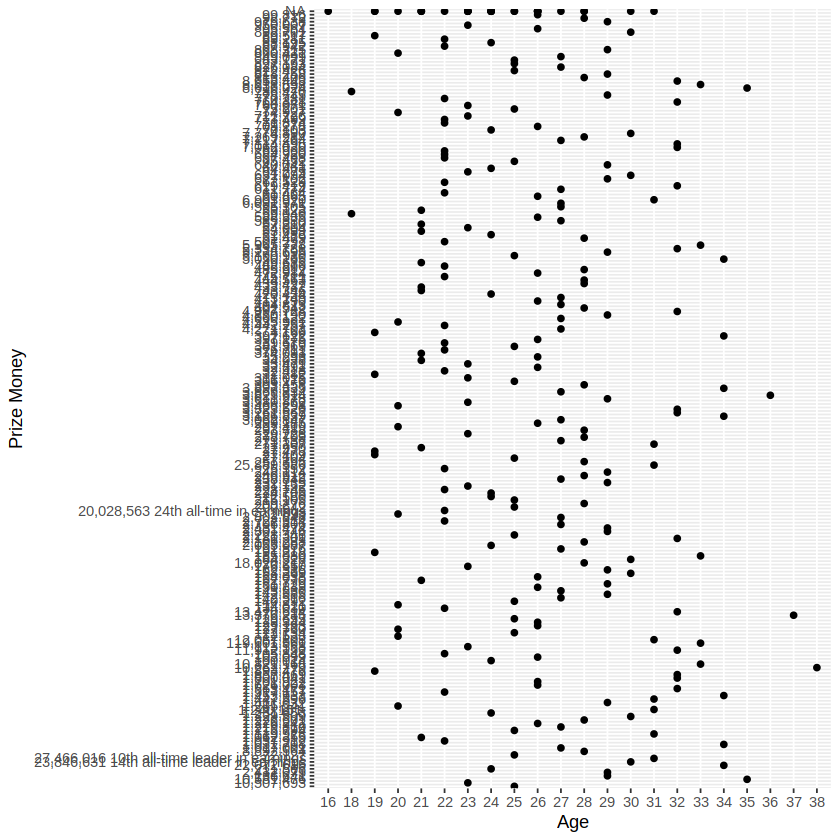

In [56]:
data <- read_csv("https://raw.githubusercontent.com/lukeelliotchan/dsci100_grp35/main/player_stats.csv") |>
    clean_names() |>
    select(current_rank, current_elo_rank, prize_money, age)
data_cleaned <- data |>
    separate(current_rank, c("current_rank", "points"), " ") |>
    separate(current_elo_rank, c("current_elo_rank", "current_elo"), " ") |>
    separate(age, c("age", "dob"), " ") |>
    #as.numeric(gsub("$", "\\1"))
    separate(prize_money, c("dollar", "prize_money"), "\\$") |>
    separate(prize_money, c("prize_money", "temp"), "  ") |>
    head(250) #training data
data_cleaned
data_tr
data_plot <- data_cleaned |>
    ggplot(aes(x=age, y= prize_money))+
    geom_point()+
    labs(x="Age", y= "Prize Money")
data_plot